In [3]:
import sys, os
import os
import torch
import torchvision.transforms as transforms

home_dir = os.path.abspath(os.getcwd()+"/../../HPE")
print(home_dir)
sys.path.append(os.path.join(home_dir, 'lib'))
sys.path.append(home_dir)

from lib.models.backbones.vit import ViT
from lib.models.heads import UncertaintyDeconvDepthWiseChannelHead
from lib.models.heads import TopdownHeatmapSimpleHead
from lib.dataset.coco import COCODataset
from lib.core.config import config
from lib.core.config import update_config
from lib.models.extra.vit_huge_uncertainty_config import extra

from lib.models.uncertainty_pose import UncertaintyPose
from lib.models.vit_pose import ViTPose

from lib.utils.vis import display_heatamp, display_keypoints, display_keypoints_with_uncertainty, coco_info
import cv2
import numpy as np


torch.cuda.is_available()

/home/yongju/Github/HPE_HOI/HPE


True

## Load config info

In [4]:

update_config(home_dir + '/experiments/coco/vit/vit_huge_uncertainty.yaml')

config.DATASET.TARGET_KEYPOINT = True
config.DATASET.TARGET_HEATMAP = True

config.TEST.USE_GT_BBOX = True

## Load dataset

In [5]:

normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)


test_dataset = COCODataset(
    cfg=config, 
    root= '/data/coco/', 
    image_set='val2017', 
    is_train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    ),
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=True,
    num_workers=config.WORKERS,
    pin_memory=True,
)


loading annotations into memory...
Done (t=0.16s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


In [4]:
test_loader[0]

TypeError: 'DataLoader' object is not subscriptable

### Define plot function

In [5]:
import matplotlib.pyplot as plt
def plot_img_with_kp_unc(img, target_keypoints, preds, keys, target_keypoints_weight, uncertainty ):
    fig = plt.figure(1,figsize=(20,16))

    #########################
    ax1 = fig.add_subplot(131)
    image = img[0].permute(1,2,0).detach().cpu().numpy()
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predicted_keypoints = preds.squeeze(axis=0)
    GT_keypoints_weight = target_keypoints_weight.detach().cpu().numpy()[0]
    ax1 = display_keypoints(1, preds[0], GT_keypoints_weight, ax1)
    ax1.imshow(image)
    plt.title("huge official Pred", fontsize=20)
    ax1.axis("off")

    #########################
    ax1 = fig.add_subplot(132)
    image = img[0].permute(1,2,0).detach().cpu().numpy()
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    predicted_keypoints = keys.squeeze(axis=0)
    # ax1 = display_keypoints_with_uncertainty(1, keys.squeeze(axis=0).detach()*4, GT_keypoints_weight, uncertainty[0].squeeze(),ax1, bound=1.5)
    ax1 = display_keypoints_with_uncertainty(1, keys[0], GT_keypoints_weight, uncertainty[0].squeeze(),ax1, bound=1.6)
    ax1.imshow(image)
    plt.title("huge Uncertianty Pred", fontsize=20)
    ax1.axis("off")

    #########################
    ax1 = fig.add_subplot(133)
    image = img[0].permute(1,2,0).detach().cpu().numpy()
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    GT_keypoints = target_keypoints.detach().cpu().numpy()[0]
    ax1 = display_keypoints(1, GT_keypoints, target_keypoints_weight.squeeze().detach().cpu().numpy(), ax1, draw_not_visible=False)
    ax1.imshow(image)
    plt.title("Target Keypoints", fontsize=20)
    ax1.axis("off")
    plt.show()

def get_unc_map_with_image(image:torch.tensor,unc_map:torch.tensor): 
    unc_map_ = unc_map.detach().cpu().numpy()[0,0]
    blur_map = cv2.GaussianBlur(unc_map_[3:-3,3:-3],(3,3),0.5)

    # Min-Max scaling
    min_val = np.min(blur_map)
    max_val = np.max(blur_map)
    scaled_map = (blur_map - min_val) / (max_val - min_val)
    resized_map = cv2.resize(scaled_map, (192,256), interpolation=cv2.INTER_LINEAR)
    scaled_255_map = (np.abs((1-resized_map)*255)).astype(np.uint8)

    unc_map_applied = cv2.applyColorMap(scaled_255_map, cv2.COLORMAP_JET)

    image = img[0].permute(1,2,0).detach().cpu().numpy()
    image = np.mean(image, -1)
    image_gray = np.repeat(image,3).reshape(256,192,3)

    alpha = 0.75
    blended_image = cv2.addWeighted(image_gray, alpha, (unc_map_applied/255).astype(np.float32), 1 - alpha, 0)

    return blended_image, unc_map_applied

## Load model

In [6]:
from copy import deepcopy
## Backbone - ViT
backbone = ViT(
    img_size=extra["backbone"]["img_size"],
    patch_size=extra["backbone"]["patch_size"],
    embed_dim=extra["backbone"]["embed_dim"],
    in_channels=3,
    num_heads=extra["backbone"]["num_heads"],
    depth=extra["backbone"]["depth"],
    qkv_bias=True,
    drop_path_rate = extra["backbone"]["drop_path_rate"]
)

## HEAD - Heatmap Simple Head
deconv_head = TopdownHeatmapSimpleHead(
    in_channels=extra["keypoint_head"]["in_channels"],
    num_deconv_layers=extra["keypoint_head"]["num_deconv_layers"],
    num_deconv_filters=extra["keypoint_head"]["num_deconv_filters"],
    num_deconv_kernels=extra["keypoint_head"]["num_deconv_kernels"],
    extra=dict(final_conv_kernel=1),
    out_channels=17,
)

## Uncertainty head
uncertainty_head = UncertaintyDeconvDepthWiseChannelHead(
    extra["uncertainty_channel_head"], norm_cfg=dict(type="BN")
)
model = UncertaintyPose(backbone, deconv_head, uncertainty_head, config)
model_vanila = ViTPose(deepcopy(backbone), deepcopy(deconv_head))

model.eval()
model_vanila.eval()

ViTPose(
  (backbone): ViT(
    (patch_embed): PatchEmbedding(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16), padding=(2, 2))
    )
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLP(
          (fc1): Linear(in_features=1280, out_features=5120, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=5120, out_features=1280, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((1280,), eps

### Load weight

In [7]:
checkpoint_path = home_dir + "/checkpoints/vit_huge_77_1.pth.tar" #"/checkpoints/vit_huge_uncertainty_77_1_AP.pth.tar"
checkpoint_official = home_dir + "/checkpoints/vitpose-h.pth" #checkpoints/vitpose_huge.pth"
model = model.custom_init_weights(model, checkpoint_path)

model_vanila.init_weights(checkpoint_official)
print()

checkpoint path :  /home/yongju/Github/HPE_HOI/HPE/checkpoints/vit_huge_77_1.pth.tar
Succesfully init weights..
Please verify once again!!
Not applied "seed"
Not applied "epoch"
Not applied "mmcv_version"
Succesfully init weights..
The parameters of the original pretrained model and your model are identical!



# Load test image sample 

In [8]:
img, target_keypoints, target_keypoints_weight, heatmap, heatamp_weight, meta = next(iter(test_loader))
meta['image']

['/data/coco/images/val2017/000000397354.jpg']

In [9]:
next(iter(test_loader))

[tensor([[[[0.5137, 0.5176, 0.4902,  ..., 0.5216, 0.4863, 0.4510],
           [0.5020, 0.5020, 0.4784,  ..., 0.4980, 0.4627, 0.4275],
           [0.4863, 0.4824, 0.4588,  ..., 0.4667, 0.4314, 0.3922],
           ...,
           [0.2902, 0.2745, 0.2510,  ..., 0.1373, 0.1373, 0.1373],
           [0.2863, 0.2745, 0.2510,  ..., 0.1373, 0.1373, 0.1373],
           [0.2784, 0.2706, 0.2471,  ..., 0.1373, 0.1412, 0.1412]],
 
          [[0.4863, 0.4941, 0.4627,  ..., 0.4510, 0.4157, 0.3765],
           [0.4784, 0.4784, 0.4510,  ..., 0.4314, 0.3922, 0.3529],
           [0.4627, 0.4588, 0.4275,  ..., 0.4000, 0.3608, 0.3176],
           ...,
           [0.2039, 0.2000, 0.1843,  ..., 0.1373, 0.1373, 0.1373],
           [0.1961, 0.1961, 0.1843,  ..., 0.1373, 0.1373, 0.1373],
           [0.1882, 0.1882, 0.1804,  ..., 0.1373, 0.1412, 0.1412]],
 
          [[0.4039, 0.4078, 0.3765,  ..., 0.3725, 0.3373, 0.2941],
           [0.3922, 0.3922, 0.3608,  ..., 0.3529, 0.3137, 0.2706],
           [0.3725, 0.36

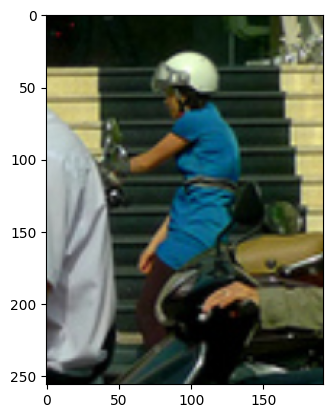

In [10]:
img, target_keypoints, target_keypoints_weight, heatmap, heatamp_weight, meta = next(iter(test_loader))

plt.imshow(img.permute(0,2,3,1)[0])

### Inference

In [11]:
print(img.shape)
with torch.no_grad():
    pose_output = model.forward(img)
    pose_output_vanila = model_vanila.forward(img)

    g_t_preds, _1 = model.get_max_preds(heatmap.detach().cpu().numpy())

keys_huge, uncertainty_huge, _, hm_huge = pose_output

preds_huge, value_huge = model.get_max_preds(hm_huge.detach().cpu().numpy())

preds_huge_vanila, _ = model.get_max_preds(pose_output_vanila.detach().cpu().numpy())

torch.Size([1, 3, 256, 192])


### Get uncertainty 

In [12]:
soft_plus = torch.nn.Softplus()

uncertainty_map_huge = soft_plus(uncertainty_huge)

if config.LOSS.USE_INDEXING:
    # kp_ = np.round(target.detach().cpu().numpy() / 4)
    # kp_ = np.round(keys_huge.detach().cpu().numpy())
    kp_ = np.round(preds_huge/4)

    x = np.clip(kp_[:, :, 0], 0, config.MODEL.HEATMAP_SIZE[0] - 1)
    y = np.clip(kp_[:, :, 1], 0, config.MODEL.HEATMAP_SIZE[1] - 1)

    # Uncertainty Map has 1 channel
    sigma_x = torch.diagonal(uncertainty_map_huge[:, 0, y, x], dim1=0, dim2=1).permute(
        1, 0
    )

    uncertainty_huge = torch.cat([sigma_x.unsqueeze(-1), sigma_x.unsqueeze(-1)], dim=-1)

# Visualization 

Left   : Official prediction result   
Middle : Ours prediction result  
Right  : Ground truth data  

joint prediction color description

> red box : labeled in ground truth data  
> green box : not labeled in ground truth data and uncertainty prediction < threshold  
> blue box : uncertainty prediction > threshold

threshold  = 1.5 (we evaluate proper value)

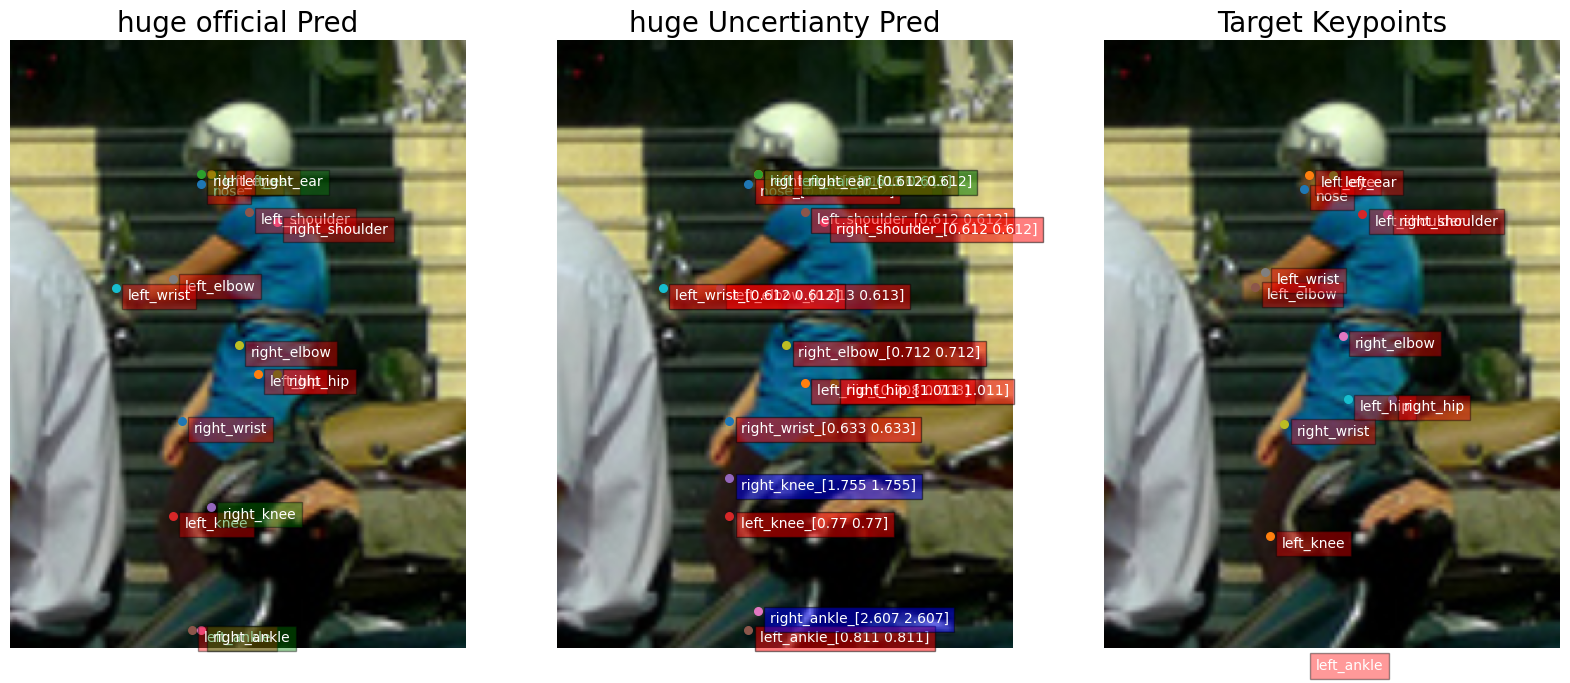

In [13]:
plot_img_with_kp_unc(img, target_keypoints, preds_huge_vanila, preds_huge, target_keypoints_weight, uncertainty_huge)

Text(0.5, 1.0, 'Blended')

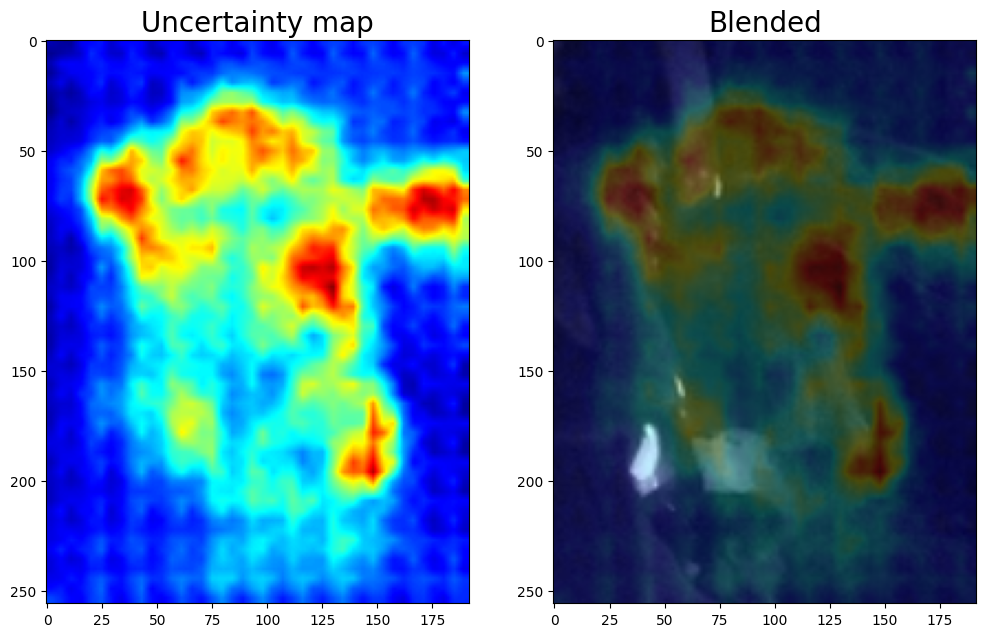

In [20]:
blended_img, unc_map_applied = get_unc_map_with_image(img, uncertainty_map_huge)

fig = plt.figure(1,figsize=(12,10))

ax1 = fig.add_subplot(121)
sigma_x = plt.imshow(unc_map_applied,cmap='jet')
plt.title(f"Uncertainty map", fontsize=20)

ax1 = fig.add_subplot(122)
plt.imshow(blended_img,cmap='jet', vmax=1, vmin=0)
plt.title(f"Blended", fontsize=20)
 